In [1]:
%load_ext autoreload
%autoreload 2

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter

import os

from model.datasets import get_loaders
from model.ddpm import DiffusionTrainer, DiffusionSampler
from model.unet import Unet
from model.training import train, sample
from model.utils import SaveBestModel, load_model, plot_images
from model.metrics import fid_score, inception_score

import gc
from tqdm.notebook import tqdm

In [34]:
torch.cuda.empty_cache()
gc.collect()

7087

In [3]:
CUDA = 0
batch_size = 32

train_loader, val_loader = get_loaders('cifar10', batch_size=batch_size)
device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")
device

Files already downloaded and verified


device(type='cuda')

In [4]:
config = {
    'lr': 2e-4,
    'start_epoch': 0,
    'n_epochs': 20,
    'warmup': 5000,
    'model_path': 'bin/cifar10.pth'
}
unet = Unet(T=1000, ch=128, ch_mult=[1, 2, 2, 2], attn=[1], num_res_blocks=2, dropout=0.1)
trainer = nn.DataParallel(DiffusionTrainer(unet)).to(device)

optimizer = optim.Adam(trainer.parameters(), lr=config['lr'])
#optimizer = optim.SGD(model.parameters(), lr=args.lr)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=lambda epoch: min(epoch, config['warmup']) / config['warmup'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

model, optimizer, scheduler, epoch, loss = load_model(trainer, optimizer, scheduler, config['model_path'])
config['start_epoch'] = epoch
model_saver = SaveBestModel(loss)

writer = SummaryWriter()

Loaded model from bin/cifar10.pth


In [22]:
train(
    trainer,
    optimizer,
    scheduler,
    train_loader,
    val_loader,
    device,
    config['start_epoch'] + config['n_epochs'],
    config['start_epoch'],
    model_saver,
    config['model_path'],
    writer
)

Validating epoch 5/24: 100%|██████████| 157/157 [00:15<00:00, 10.03it/s]


train loss: 0.03446
val loss: 0.03315
New best model with loss 0.03315 is saved


Validating epoch 6/24: 100%|██████████| 157/157 [00:15<00:00,  9.86it/s]


train loss: 0.03312
val loss: 0.03712


Validating epoch 7/24: 100%|██████████| 157/157 [00:15<00:00,  9.91it/s]


train loss: 0.03391
val loss: 0.03328


Validating epoch 8/24: 100%|██████████| 157/157 [00:15<00:00,  9.86it/s]


train loss: 0.03340
val loss: 0.03235
New best model with loss 0.03235 is saved


Validating epoch 9/24: 100%|██████████| 157/157 [00:15<00:00,  9.81it/s]


train loss: 0.03277
val loss: 0.03411


Validating epoch 10/24: 100%|██████████| 157/157 [00:15<00:00,  9.96it/s]


train loss: 0.03307
val loss: 0.03502


Validating epoch 11/24: 100%|██████████| 157/157 [00:15<00:00,  9.88it/s]


train loss: 0.03290
val loss: 0.03162
New best model with loss 0.03162 is saved


Validating epoch 12/24: 100%|██████████| 157/157 [00:15<00:00,  9.94it/s]


train loss: 0.03277
val loss: 0.02965
New best model with loss 0.02965 is saved


Validating epoch 13/24: 100%|██████████| 157/157 [00:16<00:00,  9.80it/s]


train loss: 0.03210
val loss: 0.03334


Validating epoch 14/24: 100%|██████████| 157/157 [00:16<00:00,  9.80it/s]


train loss: 0.03281
val loss: 0.03202


Validating epoch 15/24: 100%|██████████| 157/157 [00:15<00:00,  9.87it/s]


train loss: 0.03230
val loss: 0.03251


Validating epoch 16/24: 100%|██████████| 157/157 [00:16<00:00,  9.65it/s]


train loss: 0.03194
val loss: 0.03090


Validating epoch 17/24: 100%|██████████| 157/157 [00:16<00:00,  9.80it/s]


train loss: 0.03156
val loss: 0.03224


Validating epoch 18/24: 100%|██████████| 157/157 [00:15<00:00,  9.97it/s]


train loss: 0.03193
val loss: 0.03132


Validating epoch 19/24: 100%|██████████| 157/157 [00:15<00:00, 10.03it/s]


train loss: 0.03215
val loss: 0.03164


Validating epoch 20/24: 100%|██████████| 157/157 [00:15<00:00,  9.83it/s]


train loss: 0.03113
val loss: 0.03017


Validating epoch 21/24: 100%|██████████| 157/157 [00:15<00:00,  9.97it/s]


train loss: 0.03204
val loss: 0.02871
New best model with loss 0.02871 is saved


Validating epoch 22/24: 100%|██████████| 157/157 [00:16<00:00,  9.79it/s]


train loss: 0.03108
val loss: 0.03170


Validating epoch 23/24: 100%|██████████| 157/157 [00:15<00:00,  9.97it/s]


train loss: 0.03078
val loss: 0.03010


Validating epoch 24/24: 100%|██████████| 157/157 [00:16<00:00,  9.77it/s]

train loss: 0.03117
val loss: 0.03034


In [5]:
trainer.load_state_dict(torch.load(config['model_path'])['model_state_dict'])
sampler = DiffusionSampler(trainer.module.model).to(device)
sampler.eval()
print("sampler")

sampler


In [29]:
test_loader = get_loaders('cifar10', batch_size, train=False)
num_samples = len(test_loader.dataset)
num_samples

Files already downloaded and verified


10000

In [30]:
batch_images = sample(sampler, num_samples, (3, 32, 32), batch_size, device) 
torch.save(batch_images, 'fake_data.pt')

Going to sample 312 batches
Sampling #1 batch...
Sampling #2 batch...
Sampling #3 batch...
Sampling #4 batch...
Sampling #5 batch...
Sampling #6 batch...
Sampling #7 batch...
Sampling #8 batch...
Sampling #9 batch...
Sampling #10 batch...
Sampling #11 batch...
Sampling #12 batch...
Sampling #13 batch...
Sampling #14 batch...
Sampling #15 batch...
Sampling #16 batch...
Sampling #17 batch...
Sampling #18 batch...
Sampling #19 batch...
Sampling #20 batch...
Sampling #21 batch...
Sampling #22 batch...
Sampling #23 batch...
Sampling #24 batch...
Sampling #25 batch...
Sampling #26 batch...
Sampling #27 batch...
Sampling #28 batch...
Sampling #29 batch...
Sampling #30 batch...
Sampling #31 batch...
Sampling #32 batch...
Sampling #33 batch...
Sampling #34 batch...
Sampling #35 batch...
Sampling #36 batch...
Sampling #37 batch...
Sampling #38 batch...
Sampling #39 batch...
Sampling #40 batch...
Sampling #41 batch...
Sampling #42 batch...
Sampling #43 batch...
Sampling #44 batch...
Sampling #45 

In [33]:
batch_images.shape

torch.Size([10000, 3, 32, 32])

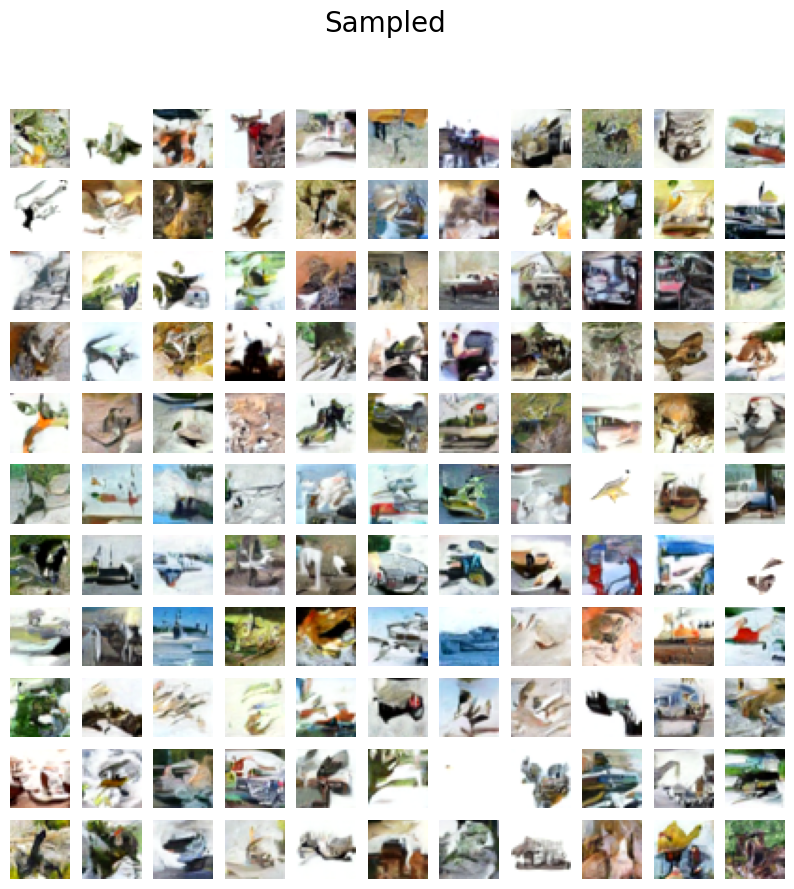

In [52]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, title, output_filename=None):
    images = images * 0.5 + 0.5
    np_images = images.numpy()
    np_images = np.clip(np_images, 0, 1)

    fig = plt.figure(figsize=(10,10))

    n_cols = int(np.sqrt(len(images)))
    n_rows = len(images) // n_cols
    index = 0

    for i in range(n_rows):
        for j in range(n_cols):
            fig.add_subplot(n_rows, n_cols, index + 1)
            plt.axis('off')
            plt.imshow(np.transpose(np_images[index], (1, 2, 0)), cmap='gray')
            index += 1
    
    fig.suptitle(title, fontsize=20)

    if output_filename is not None:
        plt.savefig(output_filename)

    plt.show()


#fake_data = torch.load('fake_data.pt')

plot_images(fake_data[128:256,...], 'Sampled', 'out/sampled.png')

In [39]:
real_data = []

for images, _ in test_loader:
    real_data.append(images)

real_data = torch.cat(real_data, dim=0)

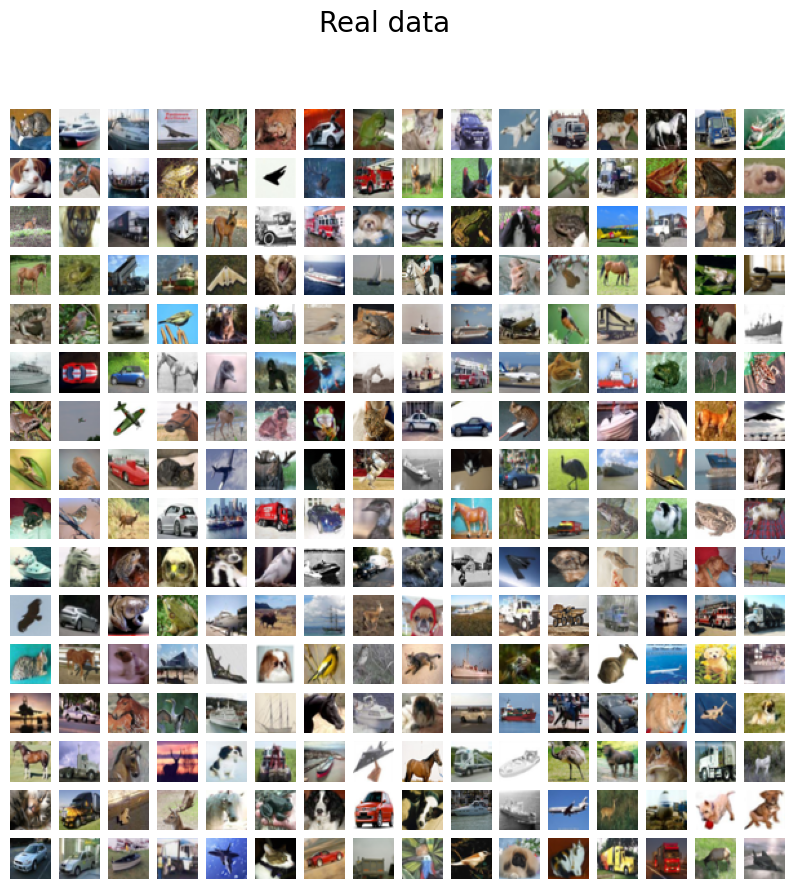

In [48]:
import matplotlib.pyplot as plt

plot_images(real_data[:128,...], 'Real data')

In [41]:
fid = fid_score(real_data, fake_data)
fid

1.433890700340271

In [42]:
real_data.shape, fake_data.shape

(torch.Size([10000, 3, 32, 32]), torch.Size([10000, 3, 32, 32]))

In [56]:
inception = inception_score(fake_data)
inception

(tensor(1.0331), tensor(0.0007))